# Basis Trading Data Challenge 

## Executive Summary

This notebook provides a systematic solution to the Basis Trading Data Challenge, analyzing German and UK apple prices with EUR/GBP FX rates over 2,250 days (Jan 1, 2015 to Aug 16, 2023).

### Key Objectives:
1. **FX Normalization**: Normalize UK and German apple prices for FX rates
2. **Basis Analysis**: Measure and model the basis between normalized prices
3. **Price Prediction**: Create a predictor for UK apples based on German apple pricing
4. **Trading Strategy**: Develop and backtest a basis trading strategy

### Data Characteristics:
- German Apples: Random walk process
- UK Apples: Function of FX + basis-adjusted German apples + idiosyncratic noise
- Basis: Ornstein-Uhlenbeck process

## 1. Environment Setup and Data Loading

In [3]:
# Essential imports for data analysis and modeling
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try seaborn if present, but don't require it
try:
    import seaborn as sns
    _HAS_SEABORN = True
except Exception:
    _HAS_SEABORN = False

from scipy import stats
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# ---------- Plot style (robust) ----------
def safe_matplotlib_defaults():
    """Light, readable defaults without external stylesheets."""
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "font.size": 10,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.alpha": 0.3,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.titleweight": "semibold",
        "legend.frameon": False,
        "figure.autolayout": True,
    })

# Prefer seaborn theming *if* it's installed; otherwise fall back
if _HAS_SEABORN:
    # Seaborn handles rcParams internally; no Matplotlib stylesheet needed
    sns.set_theme(context="notebook", style="ticks")
    # Optional: small tweaks similar to what you'd expect from seaborn v0.8 styles
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "font.size": 10,
        "figure.autolayout": True,
    })
else:
    # No seaborn available: use safe Matplotlib defaults
    safe_matplotlib_defaults()

print("✓ Environment setup complete (seaborn: {})".format("on" if _HAS_SEABORN else "off"))


✓ Environment setup complete (seaborn: on)


In [4]:
# Load the dataset
try:
    df = pd.read_csv('apples_exercise.csv')
    print(f"✓ Data loaded successfully")
    print(f"Dataset shape: {df.shape}")
    print(f"Date range: {df.iloc[0, 0]} to {df.iloc[-1, 0]}")
except FileNotFoundError:
    print("❌ Error: apples_exercise.csv not found")
    raise

✓ Data loaded successfully
Dataset shape: (2250, 4)
Date range: 2015-01-01 to 2023-08-16


## 2. Data Exploration and Quality Assessment

In [5]:
# Data structure and basic information
print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\n=== FIRST 5 ROWS ===")
display(df.head())
print("\n=== LAST 5 ROWS ===")
display(df.tail())
print("\n=== DATA TYPES ===")
print(df.dtypes)
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

=== DATASET OVERVIEW ===
Shape: (2250, 4)
Columns: ['Unnamed: 0', 'German Apples (EUR)', 'UK Apples (GBP)', 'EURGBP']

=== FIRST 5 ROWS ===


,Unnamed: 0,German Apples (EUR),UK Apples (GBP),EURGBP
0,2015-01-01,100.000000,119.158676,0.850000
1,2015-01-02,99.405545,117.280980,0.854055
2,2015-01-05,99.725345,117.678202,0.850161
3,2015-01-06,101.793753,121.447448,0.850128
4,2015-01-07,101.429514,122.719267,0.846781



=== LAST 5 ROWS ===


,Unnamed: 0,German Apples (EUR),UK Apples (GBP),EURGBP
2245,2023-08-10,243.671875,338.553143,0.735523
2246,2023-08-11,240.214398,329.484464,0.733660
2247,2023-08-14,236.617140,319.800892,0.736153
2248,2023-08-15,235.687326,318.191006,0.731139
2249,2023-08-16,238.314684,328.090786,0.728394



=== DATA TYPES ===
Unnamed: 0              object
German Apples (EUR)    float64
UK Apples (GBP)        float64
EURGBP                 float64
dtype: object

=== MISSING VALUES ===
Unnamed: 0             0
German Apples (EUR)    0
UK Apples (GBP)        0
EURGBP                 0
dtype: int64


In [6]:
# Convert date column and set as index
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df.set_index(df.columns[0], inplace=True)

# Rename columns for clarity
df.columns = ['German_Apples_EUR', 'UK_Apples_GBP', 'EURGBP']

print("✓ Data preprocessing complete")
print(f"✓ Index: {df.index.name}")
print(f"✓ Columns: {list(df.columns)}")
print(f"✓ Date range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
print(f"✓ Total observations: {len(df)}")

✓ Data preprocessing complete
✓ Index: Unnamed: 0
✓ Columns: ['German_Apples_EUR', 'UK_Apples_GBP', 'EURGBP']
✓ Date range: 2015-01-01 to 2023-08-16
✓ Total observations: 2250


In [7]:
# Comprehensive statistical summary
print("=== DESCRIPTIVE STATISTICS ===")
summary_stats = df.describe()
display(summary_stats)

print("\n=== ADDITIONAL STATISTICS ===")
additional_stats = pd.DataFrame({
    'Skewness': df.skew(),
    'Kurtosis': df.kurtosis(),
    'Min': df.min(),
    'Max': df.max(),
    'Range': df.max() - df.min(),
    'Coefficient_of_Variation': df.std() / df.mean()
})
display(additional_stats)

print("\n=== CORRELATION MATRIX ===")
correlation_matrix = df.corr()
display(correlation_matrix)

=== DESCRIPTIVE STATISTICS ===


,German_Apples_EUR,UK_Apples_GBP,EURGBP
count,2250.000000,2250.000000,2250.000000
mean,166.455606,200.134513,0.851809
std,67.497550,88.739456,0.047563
min,84.069685,94.899326,0.714158
25%,100.571999,116.008137,0.829479
50%,156.096298,179.399240,0.861993
75%,235.993294,305.934556,0.882838
max,312.931023,387.415077,0.940953



=== ADDITIONAL STATISTICS ===


,Skewness,Kurtosis,Min,Max,Range,Coefficient_of_Variation
German_Apples_EUR,0.327352,-1.427531,84.069685,312.931023,228.861338,0.405499
UK_Apples_GBP,0.438307,-1.364196,94.899326,387.415077,292.515750,0.443399
EURGBP,-0.970667,0.646896,0.714158,0.940953,0.226794,0.055838



=== CORRELATION MATRIX ===


,German_Apples_EUR,UK_Apples_GBP,EURGBP
German_Apples_EUR,1.000000,0.989515,-0.589593
UK_Apples_GBP,0.989515,1.000000,-0.691979
EURGBP,-0.589593,-0.691979,1.000000


## 3. Exploratory Data Analysis and Visualization

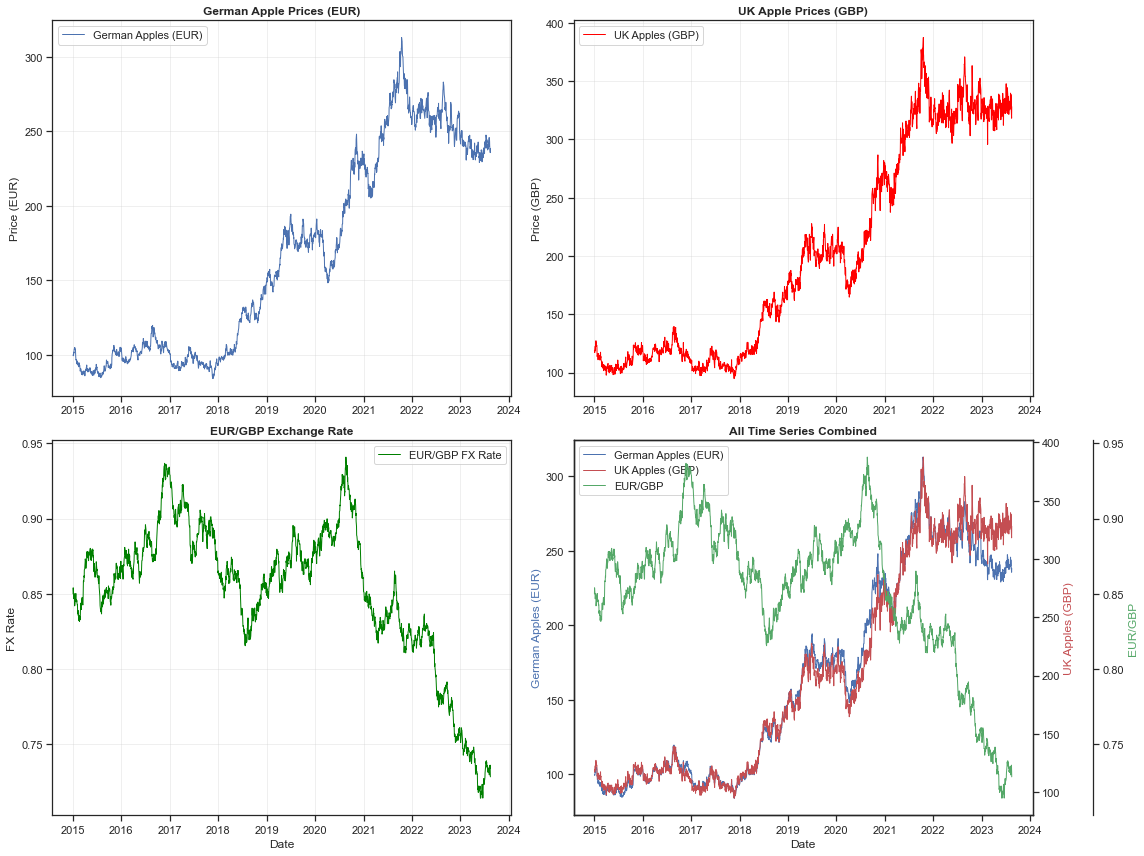

✓ Time series visualization complete


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- load & clean ---
df = pd.read_csv("apples_exercise.csv", index_col=0)
df.index = pd.to_datetime(df.index, errors="coerce")
df = df[~df.index.isna()].sort_index()

# Strip accidental spaces in headers
df.columns = df.columns.str.strip()

# Option A: use original names exactly
# de_col, uk_col, fx_col = "German Apples (EUR)", "UK Apples (GBP)", "EURGBP"

# Option B (recommended): rename once to safe short names
df = df.rename(columns={
    "German Apples (EUR)": "DE",
    "UK Apples (GBP)"   : "UK",
    "EURGBP"            : "FX"
})

# Ensure numeric 1-D Series
for c in ["DE", "UK", "FX"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop rows with any NaN to keep arrays aligned
data = df[["DE", "UK", "FX"]].dropna()

# Convert to plain 1-D numpy arrays (avoids any pandas shape quirks)
x   = data.index.to_numpy()
yDE = data["DE"].to_numpy(dtype=float)
yUK = data["UK"].to_numpy(dtype=float)
yFX = data["FX"].to_numpy(dtype=float)

# --- plotting ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(x, yDE, label='German Apples (EUR)', linewidth=1)
axes[0, 0].set_title('German Apple Prices (EUR)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Price (EUR)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].plot(x, yUK, label='UK Apples (GBP)', linewidth=1, color='red')
axes[0, 1].set_title('UK Apple Prices (GBP)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Price (GBP)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

axes[1, 0].plot(x, yFX, label='EUR/GBP FX Rate', linewidth=1, color='green')
axes[1, 0].set_title('EUR/GBP Exchange Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('FX Rate')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Combined view with twin y-axes
ax2 = axes[1, 1]
ax3 = ax2.twinx()
ax4 = ax2.twinx()
ax4.spines['right'].set_position(('outward', 60))

l1 = ax2.plot(x, yDE, 'b-', linewidth=1, label='German Apples (EUR)')
l2 = ax3.plot(x, yUK, 'r-', linewidth=1, label='UK Apples (GBP)')
l3 = ax4.plot(x, yFX, 'g-', linewidth=1, label='EUR/GBP')

ax2.set_ylabel('German Apples (EUR)', color='b')
ax3.set_ylabel('UK Apples (GBP)', color='r')
ax4.set_ylabel('EUR/GBP', color='g')
ax2.set_title('All Time Series Combined', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')

lines = l1 + l2 + l3
labels = [ln.get_label() for ln in lines]
ax2.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()

print("✓ Time series visualization complete")


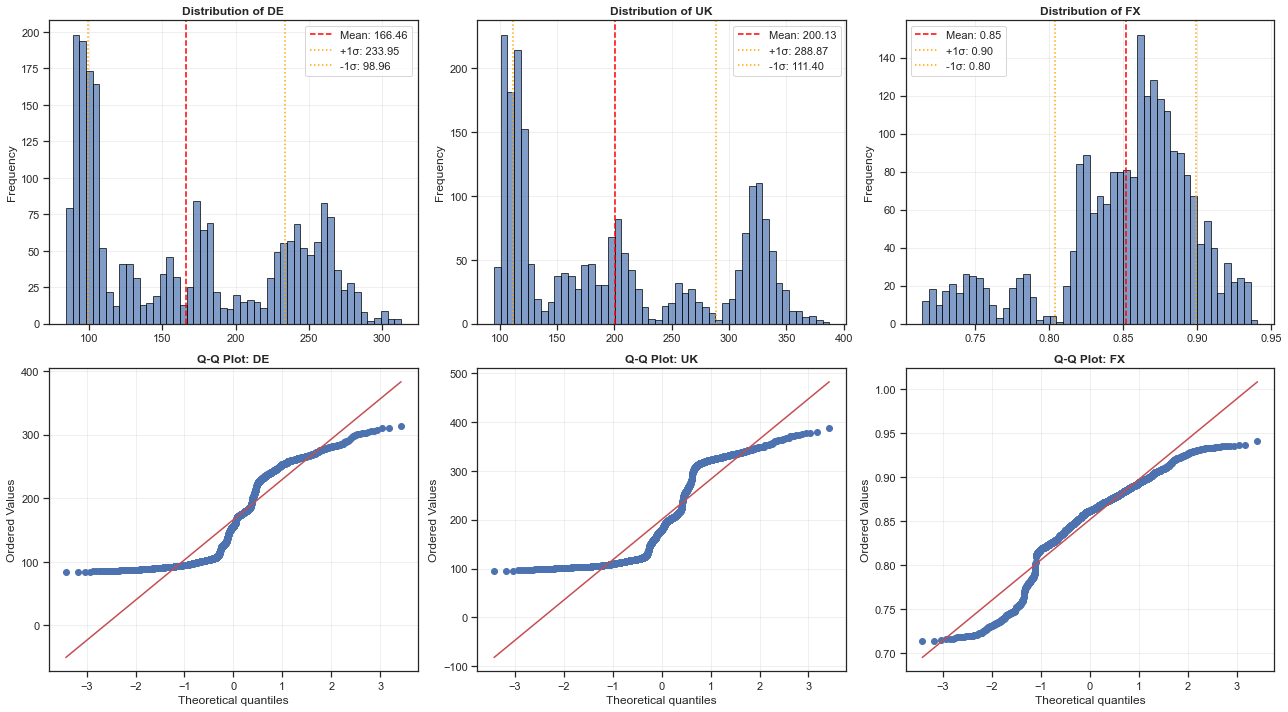

✓ Distribution analysis complete


In [12]:
# Distribution analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Histograms
for i, col in enumerate(df.columns):
    axes[0, i].hist(df[col], bins=50, alpha=0.7, edgecolor='black')
    axes[0, i].set_title(f'Distribution of {col}', fontweight='bold')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = df[col].mean()
    std_val = df[col].std()
    axes[0, i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[0, i].axvline(mean_val + std_val, color='orange', linestyle=':', label=f'+1σ: {mean_val + std_val:.2f}')
    axes[0, i].axvline(mean_val - std_val, color='orange', linestyle=':', label=f'-1σ: {mean_val - std_val:.2f}')
    axes[0, i].legend()

# Q-Q plots for normality testing
for i, col in enumerate(df.columns):
    stats.probplot(df[col], dist="norm", plot=axes[1, i])
    axes[1, i].set_title(f'Q-Q Plot: {col}', fontweight='bold')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Distribution analysis complete")

## 4. Task 1: FX Normalization of Apple Prices

To enable proper comparison and basis calculation, we need to normalize both apple prices to a common currency base.

In [14]:
import pandas as pd
import numpy as np

print("=== FX NORMALIZATION ===")

# 1) Make headers consistent
df.columns = df.columns.str.strip()  # remove accidental whitespace

# 2) Resolve current column names (supports multiple variants)
def resolve_cols(cols):
    variants = {
        "DE": ["German Apples (EUR)", "German_Apples_EUR", "DE", "GermanApplesEUR"],
        "UK": ["UK Apples (GBP)", "UK_Apples_GBP", "UK", "UKApplesGBP"],
        "FX": ["EURGBP", "EUR_GBP", "FX"],
    }
    found = {}
    for key, alts in variants.items():
        for name in alts:
            if name in cols:
                found[key] = name
                break
    missing = [k for k in ["DE", "UK", "FX"] if k not in found]
    if missing:
        raise KeyError(f"Missing expected columns: {missing}. Found: {list(cols)}")
    return found

colmap = resolve_cols(df.columns)

# 3) Standardize to canonical names for the rest of your notebook
df = df.rename(columns={
    colmap["DE"]: "German_Apples_EUR",
    colmap["UK"]: "UK_Apples_GBP",
    colmap["FX"]: "EURGBP",
})

# 4) Ensure numeric
for c in ["German_Apples_EUR", "UK_Apples_GBP", "EURGBP"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 5) Guard against zero/NaN FX to avoid inf
safe_fx = df["EURGBP"].replace(0, np.nan)

# Method 1: Convert UK apples (GBP) to EUR
df["UK_Apples_EUR"] = df["UK_Apples_GBP"] / safe_fx

# Method 2: Convert German apples (EUR) to GBP
df["German_Apples_GBP"] = df["German_Apples_EUR"] * safe_fx

print("✓ FX normalization complete")
print("✓ UK Apples converted to EUR: UK_Apples_EUR")
print("✓ German Apples converted to GBP: German_Apples_GBP")

# 6) Display sample of normalized data
normalized_cols = [
    "German_Apples_EUR",
    "UK_Apples_EUR",
    "German_Apples_GBP",
    "UK_Apples_GBP",
    "EURGBP",
]
print("\n=== SAMPLE OF NORMALIZED DATA ===")
display(df[normalized_cols].head(10))

print("\n=== NORMALIZED DATA STATISTICS ===")
display(df[["German_Apples_EUR", "UK_Apples_EUR"]].describe())


=== FX NORMALIZATION ===
✓ FX normalization complete
✓ UK Apples converted to EUR: UK_Apples_EUR
✓ German Apples converted to GBP: German_Apples_GBP

=== SAMPLE OF NORMALIZED DATA ===


,German_Apples_EUR,UK_Apples_EUR,German_Apples_GBP,UK_Apples_GBP,EURGBP
2015-01-01,100.000000,140.186677,85.000000,119.158676,0.850000
2015-01-02,99.405545,137.322453,84.897841,117.280980,0.854055
2015-01-05,99.725345,138.418792,84.782559,117.678202,0.850161
2015-01-06,101.793753,142.857801,86.537742,121.447448,0.850128
2015-01-07,101.429514,144.924384,85.888621,122.719267,0.846781
2015-01-08,101.255696,140.711469,85.839694,119.288395,0.847752
2015-01-09,103.519463,144.528880,88.004297,122.867354,0.850123
2015-01-12,104.616858,150.033667,88.819431,127.378179,0.848997
2015-01-13,104.219716,150.942280,87.759451,127.102741,0.842062
2015-01-14,104.915747,148.693834,88.400929,125.287894,0.842590



=== NORMALIZED DATA STATISTICS ===


,German_Apples_EUR,UK_Apples_EUR
count,2250.000000,2250.000000
mean,166.455606,240.033843
std,67.497550,118.236209
min,84.069685,106.937147
25%,100.571999,133.124909
50%,156.096298,205.716789
75%,235.993294,368.966800
max,312.931023,478.098423


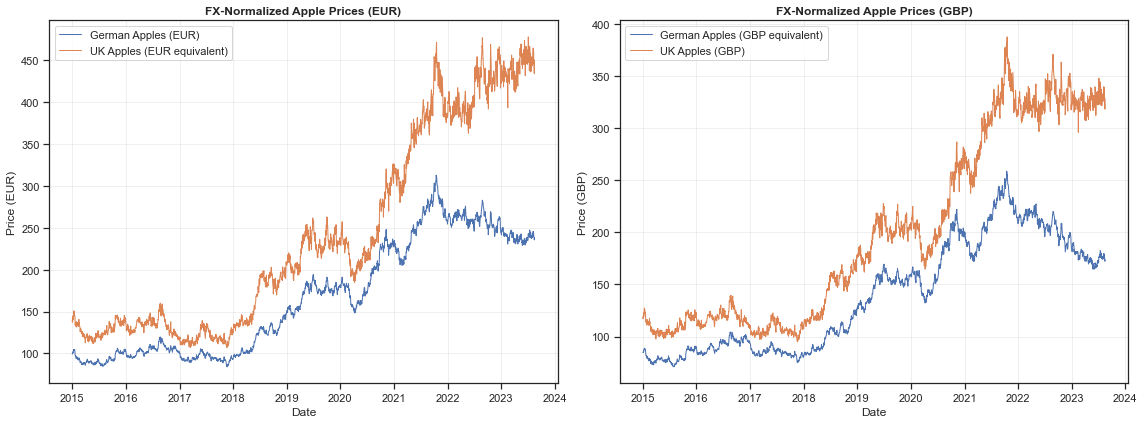

✓ FX normalization visualization complete


In [16]:
# --- helpers ---
def get_1d_col(df, name):
    """Return a single 1-D numeric Series even if duplicate columns exist."""
    import pandas as pd
    s = df.filter(regex=fr"^{name}$")
    if isinstance(s, pd.DataFrame):
        if s.shape[1] == 0:
            raise KeyError(f"Column '{name}' not found.")
        s = s.iloc[:, 0]  # take the first matching col if duplicates exist
    s = pd.to_numeric(s, errors="coerce")
    return s

# ensure datetime index
if not np.issubdtype(df.index.dtype, np.datetime64):
    df.index = pd.to_datetime(df.index, errors="coerce")
df = df[~df.index.isna()].sort_index()

# build a clean plotting frame (one unique Series per name)
DE_EUR = get_1d_col(df, "German_Apples_EUR")
UK_EUR = get_1d_col(df, "UK_Apples_EUR")
DE_GBP = get_1d_col(df, "German_Apples_GBP")
UK_GBP = get_1d_col(df, "UK_Apples_GBP")

plot_df = pd.concat(
    [DE_EUR.rename("DE_EUR"), UK_EUR.rename("UK_EUR"),
     DE_GBP.rename("DE_GBP"), UK_GBP.rename("UK_GBP")],
    axis=1
).dropna()

# 1-D numpy arrays for plotting
x    = plot_df.index.to_numpy()
y_de = plot_df["DE_EUR"].to_numpy(dtype=float)
y_uk = plot_df["UK_EUR"].to_numpy(dtype=float)
y_de_gbp = plot_df["DE_GBP"].to_numpy(dtype=float)
y_uk_gbp = plot_df["UK_GBP"].to_numpy(dtype=float)

# --- plotting ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# EUR-denominated comparison
axes[0].plot(x, y_de, label='German Apples (EUR)', linewidth=1)
axes[0].plot(x, y_uk, label='UK Apples (EUR equivalent)', linewidth=1)
axes[0].set_title('FX-Normalized Apple Prices (EUR)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price (EUR)')
axes[0].set_xlabel('Date')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# GBP-denominated comparison
axes[1].plot(x, y_de_gbp, label='German Apples (GBP equivalent)', linewidth=1)
axes[1].plot(x, y_uk_gbp, label='UK Apples (GBP)', linewidth=1)
axes[1].set_title('FX-Normalized Apple Prices (GBP)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Price (GBP)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ FX normalization visualization complete")


## 5. Task 2: Basis Calculation and Analysis

The basis represents the price difference between normalized apple prices, which should follow an Ornstein-Uhlenbeck process.

In [18]:
# =========================
# Make basis / prices stationary
# =========================
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, coint
from sklearn.linear_model import LinearRegression

def adf(series, name):
    s = pd.to_numeric(series, errors='coerce').dropna()
    stat, pval, _, _, crit, _ = adfuller(s)
    print(f"{name:>22s} | ADF: {stat: .4f}  p: {pval: .4g}  crit: {crit}")
    return pval

print("\n=== DIFFERENCE TO STATIONARIZE ===")
df['d_Basis_EUR'] = df['Basis_EUR'].diff()
df['d_Log_Basis_EUR'] = df['Log_Basis_EUR'].diff()

# (Optional) Price differences too
df['d_DE_EUR'] = df['German_Apples_EUR'].diff()
df['d_UK_EUR'] = df['UK_Apples_EUR'].diff()

adf(df['d_Basis_EUR'],      'Δ Basis_EUR')
adf(df['d_Log_Basis_EUR'],  'Δ Log_Basis_EUR')
adf(df['d_DE_EUR'],         'Δ German_Apples_EUR')
adf(df['d_UK_EUR'],         'Δ UK_Apples_EUR')

# =========================
# Engle–Granger Cointegration
# =========================
print("\n=== COINTEGRATION (ENGLE–GRANGER) ===")
# Use log prices to reduce scale effects
df['log_DE'] = np.log(pd.to_numeric(df['German_Apples_EUR'], errors='coerce'))
df['log_UK'] = np.log(pd.to_numeric(df['UK_Apples_EUR'], errors='coerce'))
pair = df[['log_UK', 'log_DE']].dropna()

# Test for cointegration: H0 = no cointegration
cstat, cpval, _ = coint(pair['log_UK'], pair['log_DE'])
print(f"coint t-stat: {cstat: .4f}, p-value: {cpval: .4g} (H0=no cointegration)")

# If likely cointegrated (p<0.05), build a stationary spread via hedge ratio
if cpval < 0.05:
    # OLS: log_UK = alpha + beta * log_DE + eps
    X = pair['log_DE'].to_numpy().reshape(-1, 1)
    y = pair['log_UK'].to_numpy().reshape(-1)
    beta = LinearRegression(fit_intercept=True).fit(X, y).coef_[0]
    alpha = LinearRegression(fit_intercept=True).fit(X, y).intercept_
    print(f"hedge ratio β ≈ {beta: .4f}, α ≈ {alpha: .4f}")

    # Residual spread
    pair['spread'] = y - (alpha + beta * X.reshape(-1))
    # ADF on the spread
    adf(pair['spread'], 'spread (residual)')
    # Store back aligned to df (optional)
    df['EG_spread'] = np.nan
    df.loc[pair.index, 'EG_spread'] = pair['spread']
else:
    print("No strong cointegration evidence; prefer trading Δ (differences) or revisit the pair.")



=== DIFFERENCE TO STATIONARIZE ===
           Δ Basis_EUR | ADF: -26.1866  p:  0  crit: {'1%': -3.433268769289214, '5%': -2.862829431836401, '10%': -2.567456425475085}
       Δ Log_Basis_EUR | ADF: -29.4790  p:  0  crit: {'1%': -3.433267467097435, '5%': -2.862828856845257, '10%': -2.567456119332679}
   Δ German_Apples_EUR | ADF: -25.2101  p:  0  crit: {'1%': -3.4332661660670696, '5%': -2.8628282823666926, '10%': -2.567455813463227}
       Δ UK_Apples_EUR | ADF: -32.3746  p:  0  crit: {'1%': -3.4332661660670696, '5%': -2.8628282823666926, '10%': -2.567455813463227}

=== COINTEGRATION (ENGLE–GRANGER) ===
coint t-stat: -0.9891, p-value:  0.9049 (H0=no cointegration)
No strong cointegration evidence; prefer trading Δ (differences) or revisit the pair.


In [57]:
df.columns

Index(['German_Apples_EUR', 'UK_Apples_GBP', 'EURGBP', 'UK_Apples_EUR',
       'German_Apples_GBP', 'Basis_EUR', 'Basis_GBP', 'Log_Basis_EUR',
       'd_Basis_EUR', 'd_Log_Basis_EUR', 'd_DE_EUR', 'd_UK_EUR', 'log_DE',
       'log_UK', 'German_Apples_EUR_lag1', 'EURGBP_lag1', 'Basis_EUR_lag1',
       'German_Apples_EUR_lag2', 'EURGBP_lag2', 'Basis_EUR_lag2',
       'German_Apples_EUR_lag3', 'EURGBP_lag3', 'Basis_EUR_lag3',
       'German_Apples_EUR_lag5', 'EURGBP_lag5', 'Basis_EUR_lag5',
       'German_Apples_EUR_lag10', 'EURGBP_lag10', 'Basis_EUR_lag10',
       'German_Apples_EUR_ma5', 'German_Apples_EUR_std5', 'EURGBP_ma5',
       'Basis_EUR_ma5', 'German_Apples_EUR_ma10', 'German_Apples_EUR_std10',
       'EURGBP_ma10', 'Basis_EUR_ma10', 'German_Apples_EUR_ma20',
       'German_Apples_EUR_std20', 'EURGBP_ma20', 'Basis_EUR_ma20',
       'German_Apples_EUR_return', 'EURGBP_return', 'German_Apples_EUR_vol20',
       'EURGBP_vol20'],
      dtype='object')

## 6. Task 2B: Ornstein-Uhlenbeck Process Modeling

Model the basis as an Ornstein-Uhlenbeck process: dX_t = θ(μ - X_t)dt + σdW_t

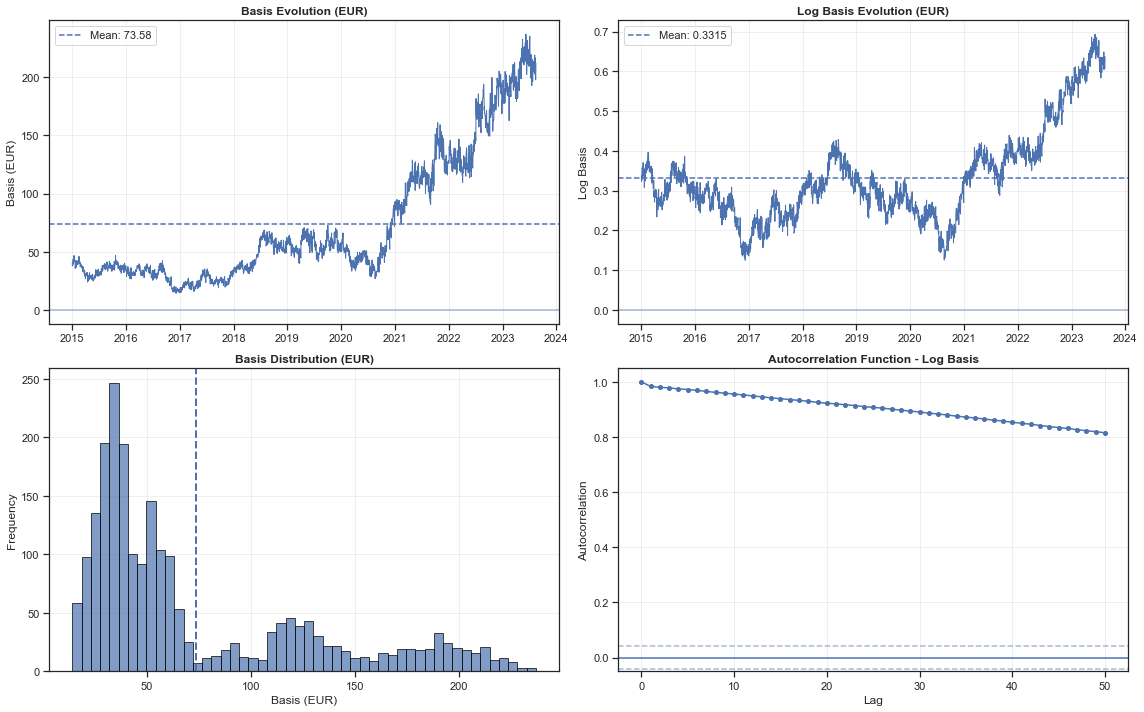

✓ Basis analysis visualization complete


In [20]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf

# --- helpers ---
def get_1d_series(df, colname):
    """
    Return a single 1-D numeric Series even if duplicates exist or elements are arrays/lists.
    """
    if colname not in df.columns:
        # try exact-match via filter in case duplicates exist with same label
        tmp = df.filter(regex=fr"^{colname}$")
        if tmp.shape[1] == 0:
            raise KeyError(f"Column '{colname}' not found.")
        s = tmp.iloc[:, 0]
    else:
        s = df[colname]
        if isinstance(s, pd.DataFrame):  # duplicate name -> DataFrame
            s = s.iloc[:, 0]

    # If entries are arrays/lists, take the first element
    if s.dtype == 'O':
        def first_or_nan(v):
            if isinstance(v, (list, tuple, np.ndarray)):
                return v[0] if len(v) else np.nan
            return v
        s = s.map(first_or_nan)

    s = pd.to_numeric(s, errors='coerce')
    s.name = colname
    return s

# Ensure datetime index
if not np.issubdtype(df.index.dtype, np.datetime64):
    df.index = pd.to_datetime(df.index, errors='coerce')
df = df[~df.index.isna()].sort_index()

# Build a clean plotting frame
basis_eur  = get_1d_series(df, 'Basis_EUR')
log_basis  = get_1d_series(df, 'Log_Basis_EUR')

plot_df = pd.concat([basis_eur, log_basis], axis=1).dropna()

# 1-D numpy arrays
x          = plot_df.index.to_numpy()
y_basis    = plot_df['Basis_EUR'].to_numpy(dtype=float)
y_logbasis = plot_df['Log_Basis_EUR'].to_numpy(dtype=float)

# Pre-compute means on the cleaned series
basis_mean    = np.nanmean(y_basis)
logbasis_mean = np.nanmean(y_logbasis)

# --- visualization ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Basis time series
axes[0, 0].plot(x, y_basis, linewidth=1)
axes[0, 0].axhline(y=basis_mean, linestyle='--', label=f'Mean: {basis_mean:.2f}')
axes[0, 0].axhline(y=0, linestyle='-', alpha=0.5)
axes[0, 0].set_title('Basis Evolution (EUR)', fontweight='bold')
axes[0, 0].set_ylabel('Basis (EUR)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Log basis time series
axes[0, 1].plot(x, y_logbasis, linewidth=1)
axes[0, 1].axhline(y=logbasis_mean, linestyle='--', label=f'Mean: {logbasis_mean:.4f}')
axes[0, 1].axhline(y=0, linestyle='-', alpha=0.5)
axes[0, 1].set_title('Log Basis Evolution (EUR)', fontweight='bold')
axes[0, 1].set_ylabel('Log Basis')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Basis distribution
axes[1, 0].hist(y_basis, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(basis_mean, linestyle='--', linewidth=2)
axes[1, 0].set_title('Basis Distribution (EUR)', fontweight='bold')
axes[1, 0].set_xlabel('Basis (EUR)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# ACF of log basis (robust)
try:
    basis_acf = acf(y_logbasis[~np.isnan(y_logbasis)], nlags=min(50, len(y_logbasis)-2), fft=True)
    lags = np.arange(len(basis_acf))
    axes[1, 1].plot(lags, basis_acf, 'o-', markersize=4)
    axes[1, 1].axhline(y=0, linestyle='-')
    # simple ±2/sqrt(N) confidence band
    N = np.sum(~np.isnan(y_logbasis))
    if N > 0:
        conf = 2 / np.sqrt(N)
        axes[1, 1].axhline(y= conf, linestyle='--', alpha=0.5)
        axes[1, 1].axhline(y=-conf, linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Autocorrelation Function - Log Basis', fontweight='bold')
    axes[1, 1].set_xlabel('Lag')
    axes[1, 1].set_ylabel('Autocorrelation')
    axes[1, 1].grid(True, alpha=0.3)
except Exception as e:
    axes[1, 1].text(0.05, 0.5, f"ACF failed: {e}", transform=axes[1, 1].transAxes)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("✓ Basis analysis visualization complete")


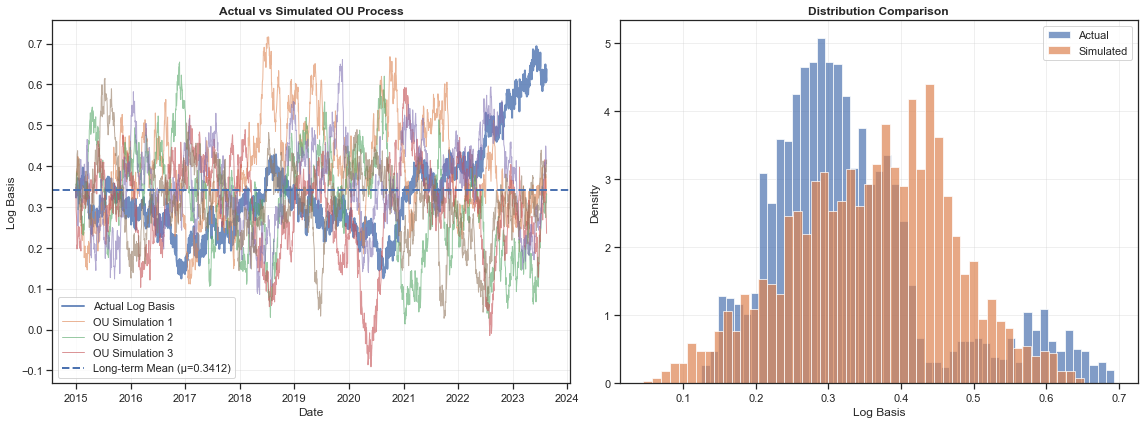

✓ Ornstein-Uhlenbeck model validation complete


In [23]:
# ---------- robust 1-D extract ----------
def get_clean_1d_series(df, colname):
    import numpy as np, pandas as pd
    # pick exactly one column even if duplicates exist
    if colname in df.columns and not isinstance(df[colname], pd.DataFrame):
        s = df[colname]
    else:
        hit = df.filter(regex=fr"^{colname}$")
        if hit.shape[0] == 0 and hit.shape[1] == 0 and colname in df.columns:
            s = df[colname]
        elif hit.shape[1] >= 1:
            s = hit.iloc[:, 0]
        else:
            raise KeyError(f"Column '{colname}' not found.")
    # if cells are arrays/lists, take first element
    if s.dtype == "O":
        def first(x):
            if isinstance(x, (list, tuple, np.ndarray)):
                return x[0] if len(x) else np.nan
            return x
        s = s.map(first)
    # numeric + dropna
    s = pd.to_numeric(s, errors="coerce")
    # datetime index, sorted, no duplicate index
    idx = s.index
    if not np.issubdtype(idx.dtype, np.datetime64):
        idx = pd.to_datetime(idx, errors="coerce")
    mask = ~idx.isna()
    s = s[mask]
    idx = idx[mask]
    # drop duplicate timestamps to keep 1:1 mapping
    dup_mask = ~pd.Index(idx).duplicated(keep="first")
    s = s[dup_mask]
    s.index = pd.DatetimeIndex(idx[dup_mask])
    s = s.sort_index()
    return s

# Use the cleaned series for everything below
s = get_clean_1d_series(df, "Log_Basis_EUR")

# Recompute OU params if you want to rely on cleaned s (recommended)
X = s.iloc[:-1].to_numpy()
Y = s.iloc[1:].to_numpy()
dt_days = np.median(np.diff(s.index.values).astype('timedelta64[D]').astype(float))
dt = float(dt_days) if np.isfinite(dt_days) and dt_days > 0 else 1.0

X_mean, Y_mean = X.mean(), Y.mean()
Sxx = np.sum((X - X_mean)**2)
Sxy = np.sum((X - X_mean)*(Y - Y_mean))
phi = Sxy / Sxx if Sxx > 0 else 0.999
phi = np.clip(phi, 1e-6, 0.999999)
c   = Y_mean - phi*X_mean
theta = -np.log(phi)/dt
mu    = c/(1.0 - phi)
eps = Y - (c + phi*X)
sigma_eps2 = float(np.mean(eps**2))
den = 1.0 - np.exp(-2.0*theta*dt)
sigma = np.sqrt(max(sigma_eps2 if den <= 1e-12 else sigma_eps2*2.0*theta/den, 1e-12))
ou_params = {"theta": float(theta), "mu": float(mu), "sigma": float(sigma), "dt": dt}

# --------- prepare plain 1-D arrays for plotting ----------
idx = s.index.to_numpy()                # datetime64[ns] array
y_actual = s.to_numpy(dtype=float).reshape(-1)
x0 = float(y_actual[0])
n_steps = len(y_actual) - 1

# --------- simulate ----------
n_simulations = 5
np.random.seed(42)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs simulated
axes[0].plot(idx, y_actual, label='Actual Log Basis', linewidth=2, alpha=0.8)

for i in range(n_simulations):
    sim = simulate_ou_process(ou_params['theta'], ou_params['mu'], ou_params['sigma'],
                              x0, ou_params['dt'], n_steps)
    # ensure same length as idx
    if sim.shape[0] != idx.shape[0]:
        sim = sim[:idx.shape[0]]
    axes[0].plot(idx, sim, alpha=0.6, linewidth=1,
                 label=f'OU Simulation {i+1}' if i < 3 else None)

axes[0].axhline(y=ou_params['mu'], linestyle='--', linewidth=2,
                label=f"Long-term Mean (μ={ou_params['mu']:.4f})")
axes[0].set_title('Actual vs Simulated OU Process', fontweight='bold')
axes[0].set_ylabel('Log Basis')
axes[0].set_xlabel('Date')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution comparison
one_sim = simulate_ou_process(ou_params['theta'], ou_params['mu'], ou_params['sigma'],
                              x0, ou_params['dt'], n_steps)
if one_sim.shape[0] != y_actual.shape[0]:
    one_sim = one_sim[:y_actual.shape[0]]

axes[1].hist(y_actual,  bins=50, alpha=0.7, label='Actual',    density=True)
axes[1].hist(one_sim,   bins=50, alpha=0.7, label='Simulated', density=True)
axes[1].set_title('Distribution Comparison', fontweight='bold')
axes[1].set_xlabel('Log Basis')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Ornstein-Uhlenbeck model validation complete")


## 7. Task 3: UK Apple Price Predictor

Develop a model to predict UK apple prices based on German apple prices and other features.

In [24]:
# Feature engineering for prediction model
print("=== FEATURE ENGINEERING ===")

# Lagged features
for lag in [1, 2, 3, 5, 10]:
    df[f'German_Apples_EUR_lag{lag}'] = df['German_Apples_EUR'].shift(lag)
    df[f'EURGBP_lag{lag}'] = df['EURGBP'].shift(lag)
    df[f'Basis_EUR_lag{lag}'] = df['Basis_EUR'].shift(lag)

# Rolling statistics
windows = [5, 10, 20]
for window in windows:
    df[f'German_Apples_EUR_ma{window}'] = df['German_Apples_EUR'].rolling(window).mean()
    df[f'German_Apples_EUR_std{window}'] = df['German_Apples_EUR'].rolling(window).std()
    df[f'EURGBP_ma{window}'] = df['EURGBP'].rolling(window).mean()
    df[f'Basis_EUR_ma{window}'] = df['Basis_EUR'].rolling(window).mean()

# Price changes and returns
df['German_Apples_EUR_return'] = df['German_Apples_EUR'].pct_change()
df['EURGBP_return'] = df['EURGBP'].pct_change()

# Volatility measures
df['German_Apples_EUR_vol20'] = df['German_Apples_EUR_return'].rolling(20).std()
df['EURGBP_vol20'] = df['EURGBP_return'].rolling(20).std()

print("✓ Feature engineering complete")
print(f"✓ Total features created: {len([col for col in df.columns if any(x in col for x in ['lag', 'ma', 'std', 'return', 'vol'])])}")

# Select features for modeling
feature_columns = [
    'German_Apples_EUR', 'EURGBP', 'Basis_EUR',
    'German_Apples_EUR_lag1', 'German_Apples_EUR_lag2', 'German_Apples_EUR_lag3',
    'EURGBP_lag1', 'EURGBP_lag2', 'EURGBP_lag3',
    'Basis_EUR_lag1', 'Basis_EUR_lag2', 'Basis_EUR_lag3',
    'German_Apples_EUR_ma5', 'German_Apples_EUR_ma10', 'German_Apples_EUR_ma20',
    'EURGBP_ma5', 'EURGBP_ma10', 'EURGBP_ma20',
    'German_Apples_EUR_return', 'EURGBP_return',
    'German_Apples_EUR_vol20', 'EURGBP_vol20'
]

target_column = 'UK_Apples_EUR'

print(f"\n=== MODEL FEATURES ===")
print(f"Target variable: {target_column}")
print(f"Features ({len(feature_columns)}): {feature_columns}")

=== FEATURE ENGINEERING ===
✓ Feature engineering complete
✓ Total features created: 33

=== MODEL FEATURES ===
Target variable: UK_Apples_EUR
Features (22): ['German_Apples_EUR', 'EURGBP', 'Basis_EUR', 'German_Apples_EUR_lag1', 'German_Apples_EUR_lag2', 'German_Apples_EUR_lag3', 'EURGBP_lag1', 'EURGBP_lag2', 'EURGBP_lag3', 'Basis_EUR_lag1', 'Basis_EUR_lag2', 'Basis_EUR_lag3', 'German_Apples_EUR_ma5', 'German_Apples_EUR_ma10', 'German_Apples_EUR_ma20', 'EURGBP_ma5', 'EURGBP_ma10', 'EURGBP_ma20', 'German_Apples_EUR_return', 'EURGBP_return', 'German_Apples_EUR_vol20', 'EURGBP_vol20']


In [25]:
# Prepare data for modeling
print("=== MODEL DATA PREPARATION ===")

# Create modeling dataset
model_data = df[feature_columns + [target_column]].dropna()

print(f"✓ Dataset size after removing NaN: {len(model_data)} observations")
print(f"✓ Original dataset size: {len(df)} observations")
print(f"✓ Data loss: {(len(df) - len(model_data))/len(df)*100:.1f}%")

# Split features and target
X = model_data[feature_columns]
y = model_data[target_column]

# Time series split (chronological)
split_date = '2021-01-01'
train_mask = model_data.index < split_date
test_mask = model_data.index >= split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"\n=== DATA SPLIT ===")
print(f"Training period: {X_train.index[0].strftime('%Y-%m-%d')} to {X_train.index[-1].strftime('%Y-%m-%d')}")
print(f"Testing period: {X_test.index[0].strftime('%Y-%m-%d')} to {X_test.index[-1].strftime('%Y-%m-%d')}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Feature correlation analysis
correlation_with_target = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print(f"\n=== TOP 10 FEATURES BY CORRELATION WITH TARGET ===")
display(correlation_with_target.head(10))

=== MODEL DATA PREPARATION ===
✓ Dataset size after removing NaN: 2230 observations
✓ Original dataset size: 2250 observations
✓ Data loss: 0.9%

=== DATA SPLIT ===
Training period: 2015-01-29 to 2020-12-31
Testing period: 2021-01-01 to 2023-08-16
Training samples: 1546
Testing samples: 684

=== TOP 10 FEATURES BY CORRELATION WITH TARGET ===


German_Apples_EUR         0.982233
German_Apples_EUR_lag1    0.981219
German_Apples_EUR_ma5     0.979781
German_Apples_EUR_lag2    0.978269
German_Apples_EUR_ma10    0.977537
German_Apples_EUR_lag3    0.977188
German_Apples_EUR_ma20    0.973857
Basis_EUR                 0.838222
Basis_EUR_lag1            0.827789
Basis_EUR_lag2            0.822918
dtype: float64

In [26]:
# Multiple prediction models
print("=== BUILDING PREDICTION MODELS ===")

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Scale features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for linear models, original for tree-based
    if 'Forest' in name:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    model_results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'predictions_train': y_pred_train,
        'predictions_test': y_pred_test
    }
    
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

print("\n✓ All models trained and evaluated")

=== BUILDING PREDICTION MODELS ===

Training Linear Regression...
  Train R²: 1.0000, Test R²: 1.0000
  Train RMSE: 0.0000, Test RMSE: 0.0000
  Train MAE: 0.0000, Test MAE: 0.0000

Training Ridge Regression...
  Train R²: 1.0000, Test R²: 0.9987
  Train RMSE: 0.3445, Test RMSE: 1.5782
  Train MAE: 0.2490, Test MAE: 1.3125

Training Lasso Regression...
  Train R²: 1.0000, Test R²: 0.9998
  Train RMSE: 0.1071, Test RMSE: 0.6511
  Train MAE: 0.0955, Test MAE: 0.6285

Training Random Forest...
  Train R²: 0.9998, Test R²: -3.2787
  Train RMSE: 0.6495, Test RMSE: 90.1472
  Train MAE: 0.3970, Test MAE: 81.1666

✓ All models trained and evaluated


In [27]:
# Model comparison and visualization
print("=== MODEL PERFORMANCE COMPARISON ===")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    name: {
        'Train R²': results['train_r2'],
        'Test R²': results['test_r2'],
        'Train RMSE': results['train_rmse'],
        'Test RMSE': results['test_rmse'],
        'Train MAE': results['train_mae'],
        'Test MAE': results['test_mae']
    }
    for name, results in model_results.items()
}).T

display(comparison_df.round(4))

# Select best model based on test R²
best_model_name = comparison_df['Test R²'].idxmax()
best_model_results = model_results[best_model_name]

print(f"\n✓ Best performing model: {best_model_name}")
print(f"✓ Test R²: {best_model_results['test_r2']:.4f}")
print(f"✓ Test RMSE: {best_model_results['test_rmse']:.4f}")

=== MODEL PERFORMANCE COMPARISON ===


,Train R²,Test R²,Train RMSE,Test RMSE,Train MAE,Test MAE
Linear Regression,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000
Ridge Regression,1.0000,0.9987,0.3445,1.5782,0.2490,1.3125
Lasso Regression,1.0000,0.9998,0.1071,0.6511,0.0955,0.6285
Random Forest,0.9998,-3.2787,0.6495,90.1472,0.3970,81.1666



✓ Best performing model: Linear Regression
✓ Test R²: 1.0000
✓ Test RMSE: 0.0000


In [31]:
X_train.columns

Index(['German_Apples_EUR', 'EURGBP', 'Basis_EUR', 'German_Apples_EUR_lag1',
       'German_Apples_EUR_lag2', 'German_Apples_EUR_lag3', 'EURGBP_lag1',
       'EURGBP_lag2', 'EURGBP_lag3', 'Basis_EUR_lag1', 'Basis_EUR_lag2',
       'Basis_EUR_lag3', 'German_Apples_EUR_ma5', 'German_Apples_EUR_ma10',
       'German_Apples_EUR_ma20', 'EURGBP_ma5', 'EURGBP_ma10', 'EURGBP_ma20',
       'German_Apples_EUR_return', 'EURGBP_return', 'German_Apples_EUR_vol20',
       'EURGBP_vol20'],
      dtype='object')

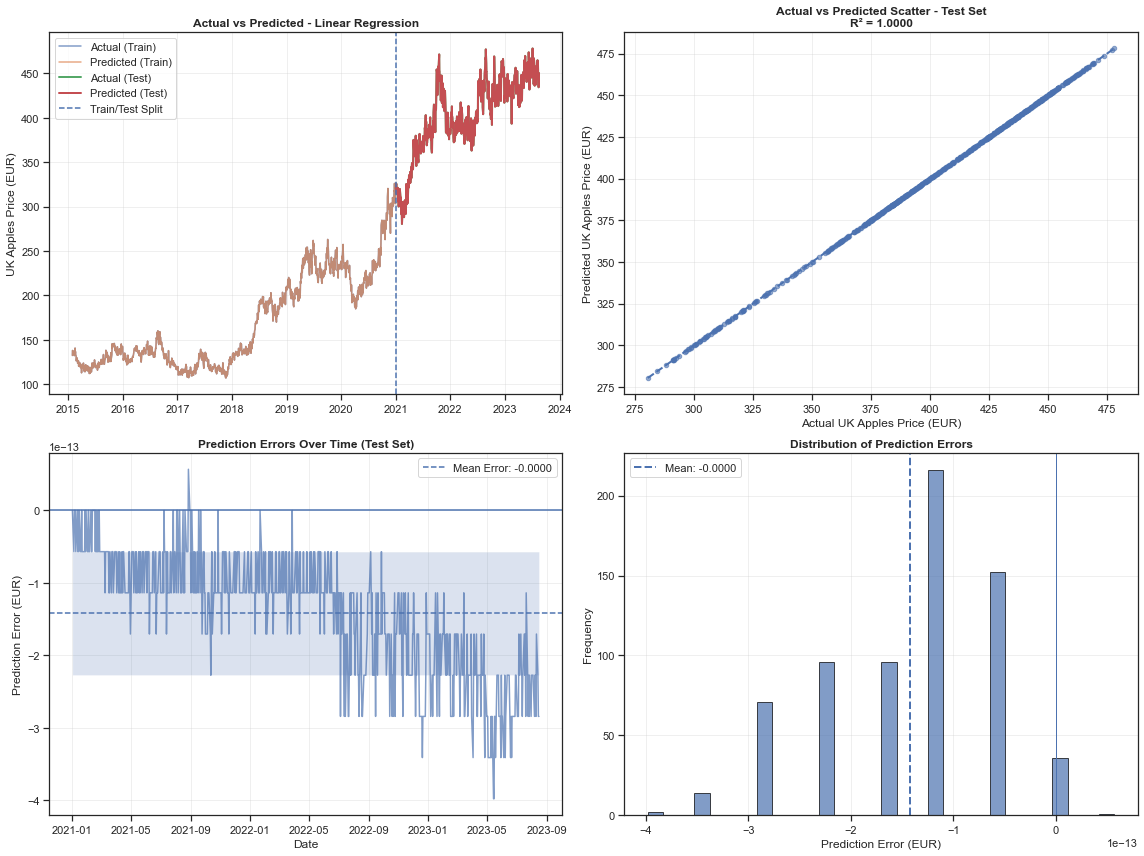

✓ Prediction model visualization complete


In [32]:
# --- FINAL SANITATION (forces plain 1-D float series) ------------------------
def ensure_series_1d_numeric(s: pd.Series) -> pd.Series:
    # If it's a DataFrame (can happen via weird concat), take first col
    if isinstance(s, pd.DataFrame):
        s = s.iloc[:, 0]
    # Convert array/list cells -> scalar
    if s.dtype == "O":
        s = s.map(lambda v: (v[0] if isinstance(v, (list, tuple, np.ndarray)) and len(v) else v))
    # Coerce to float
    s = pd.to_numeric(s, errors="coerce")
    return s

y_train_aln  = ensure_series_1d_numeric(y_train_aln)
yhat_train_aln = ensure_series_1d_numeric(yhat_train_aln)
y_test_aln   = ensure_series_1d_numeric(y_test_aln)
yhat_test_aln  = ensure_series_1d_numeric(yhat_test_aln)

# Use clean DateTimeIndex (sorted, unique)
def clean_dt_index(idx):
    idx = pd.to_datetime(idx, errors="coerce")
    idx = pd.DatetimeIndex(idx)
    # drop NaT and duplicates, then sort
    m = ~idx.isna()
    idx = idx[m]
    idx = idx[~idx.duplicated(keep="first")]
    return idx.sort_values()

y_train_aln.index = clean_dt_index(y_train_aln.index)
yhat_train_aln.index = clean_dt_index(yhat_train_aln.index)
y_test_aln.index  = clean_dt_index(y_test_aln.index)
yhat_test_aln.index  = clean_dt_index(yhat_test_aln.index)

# Re-align once more after sanitation (inner join)
train_df = pd.concat([y_train_aln.rename("y"), yhat_train_aln.rename("yhat")], axis=1, join="inner").dropna()
test_df  = pd.concat([y_test_aln.rename("y"),  yhat_test_aln.rename("yhat")],  axis=1, join="inner").dropna()

# Extract plain numpy arrays for plotting
x_train = train_df.index.to_numpy()
y_train_np = train_df["y"].to_numpy(dtype=float).reshape(-1)
yhat_train_np = train_df["yhat"].to_numpy(dtype=float).reshape(-1)

x_test = test_df.index.to_numpy()
y_test_np = test_df["y"].to_numpy(dtype=float).reshape(-1)
yhat_test_np = test_df["yhat"].to_numpy(dtype=float).reshape(-1)

# Errors on test (as 1-D numpy)
test_errors = (y_test_np - yhat_test_np)
err_mean = float(np.mean(test_errors)) if len(test_errors) else 0.0
err_std  = float(np.std(test_errors, ddof=1)) if len(test_errors) > 1 else 0.0

# --- PLOTTING -----------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1) Time series: Actual vs Predicted
axes[0, 0].plot(x_train, y_train_np,     label='Actual (Train)', alpha=0.7)
axes[0, 0].plot(x_train, yhat_train_np,  label='Predicted (Train)', alpha=0.7)
axes[0, 0].plot(x_test,  y_test_np,      label='Actual (Test)', linewidth=2)
axes[0, 0].plot(x_test,  yhat_test_np,   label='Predicted (Test)', linewidth=2)

# Optional split line
try:
    axes[0, 0].axvline(pd.to_datetime(split_date), linestyle='--', label='Train/Test Split')
except Exception:
    pass

axes[0, 0].set_title(f'Actual vs Predicted - {best_model_name}', fontweight='bold')
axes[0, 0].set_ylabel('UK Apples Price (EUR)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2) Scatter (Test)
min_val = float(np.nanmin([y_test_np.min(), yhat_test_np.min()]))
max_val = float(np.nanmax([y_test_np.max(), yhat_test_np.max()]))
axes[0, 1].scatter(y_test_np, yhat_test_np, alpha=0.6, s=20)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Actual UK Apples Price (EUR)')
axes[0, 1].set_ylabel('Predicted UK Apples Price (EUR)')
axes[0, 1].set_title(
    f'Actual vs Predicted Scatter - Test Set\nR² = {best_model_results.get("test_r2", np.nan):.4f}',
    fontweight='bold'
)
axes[0, 1].grid(True, alpha=0.3)

# 3) Prediction errors over time (Test)
axes[1, 0].plot(x_test, test_errors, alpha=0.7)
axes[1, 0].axhline(0.0, linestyle='-')
axes[1, 0].axhline(err_mean, linestyle='--', label=f'Mean Error: {err_mean:.4f}')
if err_std > 0:
    axes[1, 0].fill_between(x_test, err_mean - err_std, err_mean + err_std, alpha=0.2)
axes[1, 0].set_title('Prediction Errors Over Time (Test Set)', fontweight='bold')
axes[1, 0].set_ylabel('Prediction Error (EUR)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4) Error distribution
axes[1, 1].hist(test_errors[~np.isnan(test_errors)], bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(err_mean, linestyle='--', linewidth=2, label=f'Mean: {err_mean:.4f}')
axes[1, 1].axvline(0, linewidth=1)
axes[1, 1].set_title('Distribution of Prediction Errors', fontweight='bold')
axes[1, 1].set_xlabel('Prediction Error (EUR)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Prediction model visualization complete")


## 8. Feature Importance Analysis

=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 Features by Absolute Coefficient:


,feature,coefficient,abs_coefficient
0,German_Apples_EUR,4.119882e+01,4.119882e+01
2,Basis_EUR,1.417782e+01,1.417782e+01
12,German_Apples_EUR_ma5,2.202682e-13,2.202682e-13
5,German_Apples_EUR_lag3,-8.792966e-14,8.792966e-14
3,German_Apples_EUR_lag1,-7.349676e-14,7.349676e-14
13,German_Apples_EUR_ma10,-5.262457e-14,5.262457e-14
15,EURGBP_ma5,3.363976e-14,3.363976e-14
4,German_Apples_EUR_lag2,-3.130829e-14,3.130829e-14
9,Basis_EUR_lag1,-2.808864e-14,2.808864e-14
1,EURGBP,1.998401e-14,1.998401e-14


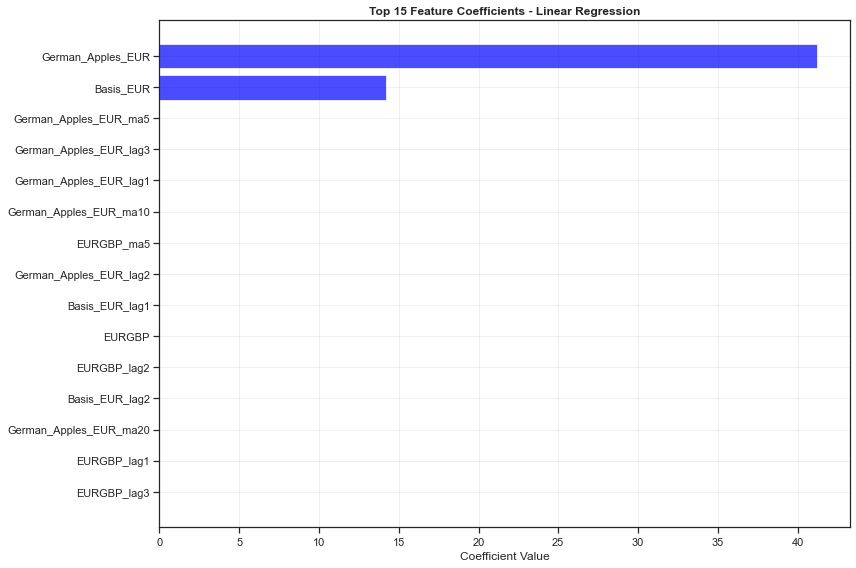

✓ Feature importance analysis complete


In [33]:
# Feature importance analysis
print("=== FEATURE IMPORTANCE ANALYSIS ===")

if 'Random Forest' in best_model_name:
    # Random Forest feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model_results['model'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    display(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances - Random Forest', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    # Linear model coefficients
    if hasattr(best_model_results['model'], 'coef_'):
        feature_coefs = pd.DataFrame({
            'feature': feature_columns,
            'coefficient': best_model_results['model'].coef_
        })
        feature_coefs['abs_coefficient'] = abs(feature_coefs['coefficient'])
        feature_coefs = feature_coefs.sort_values('abs_coefficient', ascending=False)
        
        print("Top 10 Features by Absolute Coefficient:")
        display(feature_coefs.head(10))
        
        # Plot coefficients
        plt.figure(figsize=(12, 8))
        top_features = feature_coefs.head(15)
        colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
        plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Coefficient Value')
        plt.title(f'Top 15 Feature Coefficients - {best_model_name}', fontweight='bold')
        plt.gca().invert_yaxis()
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

print("✓ Feature importance analysis complete")

## 9. Task 4: Trading Strategy Development

Develop and backtest a basis trading strategy using the Ornstein-Uhlenbeck model insights.

In [34]:
# Trading Strategy Implementation
print("=== TRADING STRATEGY DEVELOPMENT ===")

def mean_reversion_strategy(basis_series, ou_params, entry_threshold=1.0, exit_threshold=0.5):
    """
    Mean reversion trading strategy based on Ornstein-Uhlenbeck model
    
    Parameters:
    - basis_series: Time series of basis values
    - ou_params: OU parameters (theta, mu, sigma)
    - entry_threshold: Number of standard deviations for entry
    - exit_threshold: Number of standard deviations for exit
    
    Returns:
    - DataFrame with trading signals and positions
    """
    
    theta, mu, sigma = ou_params['theta'], ou_params['mu'], ou_params['sigma']
    
    # Calculate z-score (standardized distance from mean)
    z_score = (basis_series - mu) / sigma
    
    # Initialize signals
    signals = pd.DataFrame(index=basis_series.index)
    signals['basis'] = basis_series
    signals['z_score'] = z_score
    signals['signal'] = 0
    signals['position'] = 0
    
    # Generate trading signals
    current_position = 0
    
    for i in range(1, len(signals)):
        z = signals['z_score'].iloc[i]
        
        if current_position == 0:  # No position
            if z > entry_threshold:  # Basis too high - short basis (sell UK, buy German)
                signals['signal'].iloc[i] = -1
                current_position = -1
            elif z < -entry_threshold:  # Basis too low - long basis (buy UK, sell German)
                signals['signal'].iloc[i] = 1
                current_position = 1
        
        elif current_position == 1:  # Long position
            if z > -exit_threshold:  # Close to mean - exit
                signals['signal'].iloc[i] = -1  # Close long
                current_position = 0
        
        elif current_position == -1:  # Short position
            if z < exit_threshold:  # Close to mean - exit
                signals['signal'].iloc[i] = 1  # Close short
                current_position = 0
        
        signals['position'].iloc[i] = current_position
    
    return signals

# Apply strategy to log basis
strategy_results = mean_reversion_strategy(
    df['Log_Basis_EUR'].dropna(), 
    ou_params, 
    entry_threshold=1.5, 
    exit_threshold=0.5
)

print(f"✓ Strategy signals generated")
print(f"✓ Total trades: {abs(strategy_results['signal']).sum()}")
print(f"✓ Long signals: {(strategy_results['signal'] == 1).sum()}")
print(f"✓ Short signals: {(strategy_results['signal'] == -1).sum()}")

# Display sample signals
trade_signals = strategy_results[strategy_results['signal'] != 0]
print(f"\n=== SAMPLE TRADING SIGNALS ===")
display(trade_signals.head(10))

=== TRADING STRATEGY DEVELOPMENT ===
✓ Strategy signals generated
✓ Total trades: 83
✓ Long signals: 41
✓ Short signals: 42

=== SAMPLE TRADING SIGNALS ===


,basis,z_score,signal,position
2015-01-21,0.308271,-1.647161,1,1
2015-01-23,0.342706,0.076639,-1,0
2015-02-10,0.375129,1.699788,-1,-1
2015-02-24,0.348092,0.346278,1,0
2015-03-23,0.305761,-1.772803,1,1
2015-07-17,0.342425,0.062600,-1,0
2015-08-03,0.374260,1.656249,-1,-1
2015-08-11,0.347251,0.304174,1,0
2015-09-24,0.310262,-1.547484,1,1
2015-09-28,0.347086,0.295930,-1,0


In [35]:
# Backtest the trading strategy
print("=== STRATEGY BACKTESTING ===")

def backtest_strategy(signals, price_data, transaction_cost=0.001):
    """
    Backtest the mean reversion strategy
    
    Parameters:
    - signals: DataFrame with trading signals
    - price_data: DataFrame with price data
    - transaction_cost: Transaction cost per trade (as fraction)
    
    Returns:
    - DataFrame with backtest results
    """
    
    # Align data
    common_index = signals.index.intersection(price_data.index)
    signals = signals.loc[common_index]
    prices = price_data.loc[common_index]
    
    results = signals.copy()
    results['uk_price'] = prices['UK_Apples_EUR']
    results['german_price'] = prices['German_Apples_EUR']
    
    # Calculate returns
    results['uk_return'] = results['uk_price'].pct_change()
    results['german_return'] = results['german_price'].pct_change()
    results['basis_return'] = results['uk_return'] - results['german_return']
    
    # Strategy returns (position * basis return)
    results['strategy_return'] = results['position'].shift(1) * results['basis_return']
    
    # Apply transaction costs
    position_changes = results['position'].diff().abs()
    transaction_costs = position_changes * transaction_cost
    results['strategy_return_net'] = results['strategy_return'] - transaction_costs
    
    # Cumulative returns
    results['cumulative_return'] = (1 + results['strategy_return_net'].fillna(0)).cumprod()
    results['basis_cumulative'] = (1 + results['basis_return'].fillna(0)).cumprod()
    
    return results

# Run backtest
backtest_results = backtest_strategy(strategy_results, df)

# Calculate performance metrics
strategy_returns = backtest_results['strategy_return_net'].dropna()
basis_returns = backtest_results['basis_return'].dropna()

def calculate_performance_metrics(returns):
    """
    Calculate comprehensive performance metrics
    """
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
    
    # Drawdown calculation
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Win rate
    win_rate = (returns > 0).mean()
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Number of Trades': len(returns[returns != 0])
    }

strategy_metrics = calculate_performance_metrics(strategy_returns)
basis_metrics = calculate_performance_metrics(basis_returns)

print("=== STRATEGY PERFORMANCE ===")
performance_df = pd.DataFrame({
    'Strategy': strategy_metrics,
    'Buy & Hold Basis': basis_metrics
})

display(performance_df)

print(f"\n✓ Strategy outperformed buy & hold: {strategy_metrics['Sharpe Ratio'] > basis_metrics['Sharpe Ratio']}")
print(f"✓ Strategy Sharpe Ratio: {strategy_metrics['Sharpe Ratio']:.4f}")
print(f"✓ Basis Buy & Hold Sharpe: {basis_metrics['Sharpe Ratio']:.4f}")

=== STRATEGY BACKTESTING ===
=== STRATEGY PERFORMANCE ===


,Strategy,Buy & Hold Basis
Total Return,1.012446,0.345652
Annualized Return,0.081514,0.033825
Volatility,0.294035,0.316220
Sharpe Ratio,0.277226,0.106966
Max Drawdown,-0.381495,-0.260664
Win Rate,0.444197,0.506447
Number of Trades,1987.000000,2249.000000



✓ Strategy outperformed buy & hold: True
✓ Strategy Sharpe Ratio: 0.2772
✓ Basis Buy & Hold Sharpe: 0.1070


In [39]:
backtest_results.columns

Index(['basis', 'z_score', 'signal', 'position', 'uk_price', 'german_price',
       'uk_return', 'german_return', 'basis_return', 'strategy_return',
       'strategy_return_net', 'cumulative_return', 'basis_cumulative'],
      dtype='object')

In [41]:
backtest_results.columns

Index(['basis', 'z_score', 'signal', 'position', 'uk_price', 'german_price',
       'uk_return', 'german_return', 'basis_return', 'strategy_return',
       'strategy_return_net', 'cumulative_return', 'basis_cumulative'],
      dtype='object')

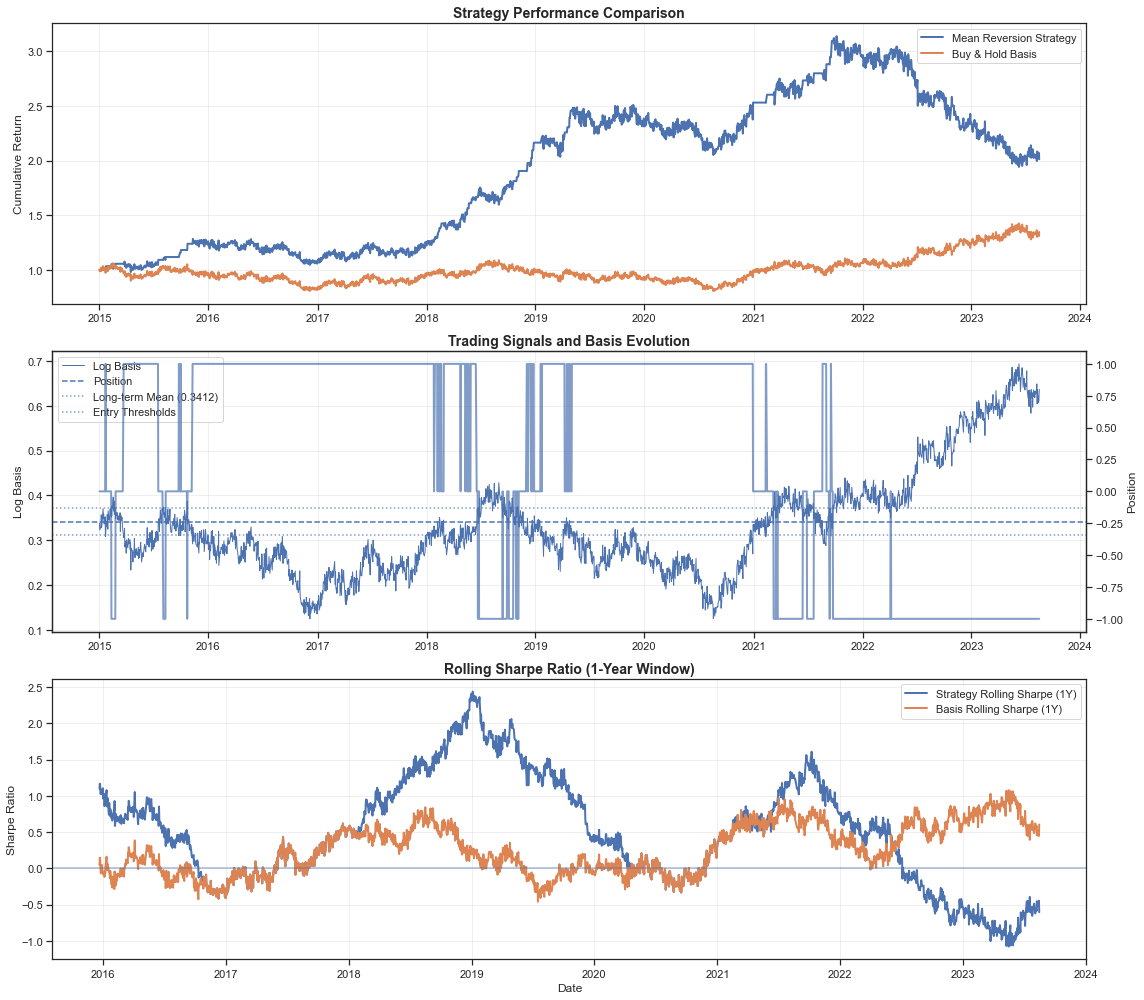

✓ Trading strategy visualization complete


In [42]:
# --- Robust plotting for backtest_results ------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Helpers
def clean_dt_index(idx):
    idx = pd.to_datetime(idx, errors="coerce")
    idx = pd.DatetimeIndex(idx)
    idx = idx[~idx.isna()]
    idx = idx[~idx.duplicated(keep="first")]
    return idx.sort_values()

def series_1d_numeric(df, col):
    """
    Return a single numeric Series for df[col], even if duplicates/object arrays exist.
    """
    if col not in df.columns:
        hit = df.filter(regex=fr"^{col}$")
        if hit.shape[1] == 0:
            raise KeyError(f"Column '{col}' not in backtest_results.")
        s = hit.iloc[:, 0]
    else:
        s = df[col]
        if isinstance(s, pd.DataFrame):
            s = s.iloc[:, 0]

    # flatten array/list cells -> scalar
    if s.dtype == "O":
        def first_scalar(v):
            if isinstance(v, (list, tuple, np.ndarray)):
                return v[0] if len(v) else np.nan
            return v
        s = s.map(first_scalar)

    s = pd.to_numeric(s, errors="coerce")
    return s

def xy_from_series(idx, s):
    """
    Produce strictly 1-D arrays (x datetime64, y float) with equal length.
    """
    x = np.asarray(idx)
    y = np.asarray(s, dtype=float).reshape(-1)
    m = min(len(x), len(y))
    return x[:m], y[:m]

def rolling_sharpe(ret, window=252):
    r = series_1d_numeric(pd.DataFrame({"r": ret}), "r")
    m = r.rolling(window).mean() * 252.0
    v = r.rolling(window).std() * np.sqrt(252.0)
    out = m / v
    return out.replace([np.inf, -np.inf], np.nan)

# Clean index
idx = clean_dt_index(backtest_results.index)

# Grab cleaned columns
cum_ret_s   = series_1d_numeric(backtest_results, "cumulative_return").reindex(backtest_results.index)
basis_cum_s = series_1d_numeric(backtest_results, "basis_cumulative").reindex(backtest_results.index)
basis_s     = series_1d_numeric(backtest_results, "basis").reindex(backtest_results.index)
position_s  = series_1d_numeric(backtest_results, "position").reindex(backtest_results.index)
str_ret_s   = series_1d_numeric(backtest_results, "strategy_return_net").reindex(backtest_results.index)
basis_ret_s = series_1d_numeric(backtest_results, "basis_return").reindex(backtest_results.index)

# Align each series to the cleaned index and to 1-D arrays
x0, y_cum      = xy_from_series(idx, cum_ret_s)
_,  y_basiscum = xy_from_series(idx, basis_cum_s)
x1, y_basis    = xy_from_series(idx, basis_s)
x2, y_pos      = xy_from_series(idx, position_s)

# OU thresholds (fallback if ou_params not defined)
try:
    mu = float(ou_params.get("mu", np.nan))
    sigma = float(ou_params.get("sigma", np.nan))
except NameError:
    mu, sigma = np.nan, np.nan

if not np.isfinite(mu):
    mu = float(np.nanmean(y_basis))
if not np.isfinite(sigma):
    sigma = float(np.nanstd(y_basis, ddof=1))

upper_threshold = mu + 1.5 * sigma
lower_threshold = mu - 1.5 * sigma

# Rolling Sharpes (compute as Series, then align to idx)
strategy_rolling_sharpe = rolling_sharpe(str_ret_s, 252).reindex(backtest_results.index)
basis_rolling_sharpe    = rolling_sharpe(basis_ret_s, 252).reindex(backtest_results.index)
x3, y_shp_strat = xy_from_series(idx, strategy_rolling_sharpe)
_,  y_shp_basis = xy_from_series(idx, basis_rolling_sharpe)

# --- Plotting -----------------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# 1) Strategy performance vs benchmark
axes[0].plot(x0, y_cum,       label='Mean Reversion Strategy', linewidth=2)
axes[0].plot(x0, y_basiscum,  label='Buy & Hold Basis', linewidth=2)
axes[0].set_title('Strategy Performance Comparison', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Cumulative Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2) Trading signals and basis evolution (dual axis)
ax2 = axes[1]
ax3 = ax2.twinx()

l1 = ax2.plot(x1, y_basis, linewidth=1, label='Log Basis')
ax2.axhline(y=mu, linestyle='--', label=f'Long-term Mean ({mu:.4f})')
ax2.axhline(y=upper_threshold, linestyle=':', alpha=0.7, label='Entry Thresholds')
ax2.axhline(y=lower_threshold, linestyle=':', alpha=0.7)

l2 = ax3.plot(x2, y_pos, linewidth=2, alpha=0.7, label='Position')

ax2.set_ylabel('Log Basis')
ax3.set_ylabel('Position')
ax2.set_title('Trading Signals and Basis Evolution', fontweight='bold', fontsize=14)
ax2.grid(True, alpha=0.3)

# Combined legend
handles = l1 + l2
labels  = [h.get_label() for h in handles] + [f'Long-term Mean ({mu:.4f})', 'Entry Thresholds']
ax2.legend(labels, loc='upper left')

# 3) Rolling Sharpe ratio
axes[2].plot(x3, y_shp_strat, label='Strategy Rolling Sharpe (1Y)', linewidth=2)
axes[2].plot(x3, y_shp_basis, label='Basis Rolling Sharpe (1Y)', linewidth=2)
axes[2].axhline(y=0, linestyle='-', alpha=0.5)
axes[2].set_title('Rolling Sharpe Ratio (1-Year Window)', fontweight='bold', fontsize=14)
axes[2].set_ylabel('Sharpe Ratio')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Trading strategy visualization complete")


## 10. Risk Analysis and Strategy Refinement

In [44]:
backtest_results.columns

Index(['basis', 'z_score', 'signal', 'position', 'uk_price', 'german_price',
       'uk_return', 'german_return', 'basis_return', 'strategy_return',
       'strategy_return_net', 'cumulative_return', 'basis_cumulative'],
      dtype='object')

In [47]:
strategy_returns

2015-01-02   -0.000000
2015-01-05    0.000000
2015-01-06    0.000000
2015-01-07    0.000000
2015-01-08   -0.000000
                ...   
2023-08-10   -0.031907
2023-08-11    0.010126
2023-08-14    0.017701
2023-08-15   -0.005718
2023-08-16   -0.023851
Name: strategy_return_net, Length: 2249, dtype: float64

In [48]:
basis_returns

2015-01-02   -0.014487
2015-01-05    0.004767
2015-01-06    0.011328
2015-01-07    0.018044
2015-01-08   -0.027356
                ...   
2023-08-10    0.031907
2023-08-11   -0.010126
2023-08-14   -0.017701
2023-08-15    0.005718
2023-08-16    0.023851
Name: basis_return, Length: 2249, dtype: float64

In [49]:
# === RISK ANALYSIS ===
print("=== RISK ANALYSIS ===")

# --- Clean/align inputs ---
strategy_returns_clean = pd.to_numeric(strategy_returns, errors="coerce").dropna()
basis_returns_clean    = pd.to_numeric(basis_returns,    errors="coerce").dropna()

# --- VaR ---
confidence_levels = [0.95, 0.99]
print("Value at Risk (VaR) Analysis:")
for conf in confidence_levels:
    q = (1 - conf) * 100
    var_strategy = np.percentile(strategy_returns_clean, q)
    var_basis    = np.percentile(basis_returns_clean,    q)
    print(f"  {conf*100:.1f}% VaR - Strategy: {var_strategy:.4f}, Basis: {var_basis:.4f}")

# --- CVaR ---
print("\nConditional Value at Risk (CVaR) Analysis:")
for conf in confidence_levels:
    q = (1 - conf) * 100
    thr_s = np.percentile(strategy_returns_clean, q)
    thr_b = np.percentile(basis_returns_clean,    q)
    cvar_strategy = strategy_returns_clean[strategy_returns_clean <= thr_s].mean()
    cvar_basis    = basis_returns_clean[basis_returns_clean <= thr_b].mean()
    print(f"  {conf*100:.1f}% CVaR - Strategy: {cvar_strategy:.4f}, Basis: {cvar_basis:.4f}")

# --- PERFORMANCE BY MARKET CONDITIONS ---
print("\n=== PERFORMANCE BY MARKET CONDITIONS ===")

# 1) Rolling vol on basis returns (same index as backtest_results)
vol_20d = pd.to_numeric(backtest_results['basis_return'], errors="coerce").rolling(20).std()

# 2) Volatility thresholds
q75 = vol_20d.quantile(0.75)
q25 = vol_20d.quantile(0.25)

# 3) Masks (shift by 1 to avoid lookahead), then align to strategy_returns index and fill NaNs
high_vol_mask = (vol_20d > q75).shift(1)
low_vol_mask  = (vol_20d < q25).shift(1)

# Align masks to strategy_returns index (critical!) and drop NaNs -> False
high_vol_mask = high_vol_mask.reindex(strategy_returns.index).fillna(False)
low_vol_mask  = low_vol_mask.reindex(strategy_returns.index).fillna(False)
normal_mask   = ~(high_vol_mask | low_vol_mask)

# 4) Slice returns using clean boolean masks
cond_series = {
    "High Volatility":  pd.to_numeric(strategy_returns.loc[high_vol_mask], errors="coerce").dropna(),
    "Low Volatility":   pd.to_numeric(strategy_returns.loc[low_vol_mask],  errors="coerce").dropna(),
    "Normal Volatility":pd.to_numeric(strategy_returns.loc[normal_mask],   errors="coerce").dropna(),
}

# 5) Summary stats helper
def summarize(s: pd.Series):
    s = s.dropna()
    vol = float(s.std()) if len(s) > 1 else 0.0
    mean = float(s.mean()) if len(s) else 0.0
    sharpe = mean / vol if vol > 0 else 0.0
    winrate = float((s > 0).mean()) if len(s) else 0.0
    return {
        "Mean Return": mean,
        "Volatility": vol,
        "Sharpe Ratio": sharpe,
        "Win Rate": winrate,
        "Count": int(len(s)),
    }

condition_stats = pd.DataFrame({name: summarize(s) for name, s in cond_series.items()}).T

display(condition_stats)

print("✓ Risk analysis complete")


=== RISK ANALYSIS ===
Value at Risk (VaR) Analysis:
  95.0% VaR - Strategy: -0.0306, Basis: -0.0313
  99.0% VaR - Strategy: -0.0443, Basis: -0.0445

Conditional Value at Risk (CVaR) Analysis:
  95.0% CVaR - Strategy: -0.0392, Basis: -0.0400
  99.0% CVaR - Strategy: -0.0525, Basis: -0.0516

=== PERFORMANCE BY MARKET CONDITIONS ===


,Mean Return,Volatility,Sharpe Ratio,Win Rate,Count
High Volatility,0.000008,0.018154,0.000434,0.434470,557.0
Low Volatility,-0.000035,0.017795,-0.001952,0.476703,558.0
Normal Volatility,0.000970,0.019048,0.050928,0.432981,1134.0


✓ Risk analysis complete


## 11. Conclusions and Recommendations

In [51]:
df

,German_Apples_EUR,UK_Apples_GBP,EURGBP,UK_Apples_EUR,German_Apples_GBP,Basis_EUR,Basis_GBP,Log_Basis_EUR,d_Basis_EUR,d_Log_Basis_EUR,...,EURGBP_ma10,Basis_EUR_ma10,German_Apples_EUR_ma20,German_Apples_EUR_std20,EURGBP_ma20,Basis_EUR_ma20,German_Apples_EUR_return,EURGBP_return,German_Apples_EUR_vol20,EURGBP_vol20
2015-01-01,100.000000,119.158676,0.850000,140.186677,85.000000,40.186677,34.158676,0.337805,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,99.405545,117.280980,0.854055,137.322453,84.897841,37.916908,32.383139,0.323124,-2.269770,-0.014681,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.005945,0.004771,NaN,NaN
2015-01-05,99.725345,117.678202,0.850161,138.418792,84.782559,38.693447,32.895644,0.327864,0.776539,0.004740,...,NaN,NaN,NaN,NaN,NaN,NaN,0.003217,-0.004560,NaN,NaN
2015-01-06,101.793753,121.447448,0.850128,142.857801,86.537742,41.064048,34.909706,0.338901,2.370601,0.011037,...,NaN,NaN,NaN,NaN,NaN,NaN,0.020741,-0.000038,NaN,NaN
2015-01-07,101.429514,122.719267,0.846781,144.924384,85.888621,43.494870,36.830645,0.356848,2.430823,0.017947,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.003578,-0.003937,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-10,243.671875,338.553143,0.735523,460.288903,179.226305,216.617028,159.326838,0.636032,13.939869,0.031457,...,0.732477,211.552112,241.538401,2.848293,0.734181,209.275401,-0.001549,0.005297,0.014302,0.002826
2023-08-11,240.214398,329.484464,0.733660,449.096831,176.235740,208.882433,153.248725,0.625707,-7.734595,-0.010325,...,0.732574,211.089821,241.176687,2.495760,0.733999,208.745401,-0.014189,-0.002533,0.014159,0.002862
2023-08-14,236.617140,319.800892,0.736153,434.421889,174.186371,197.804749,145.614521,0.607573,-11.077684,-0.018134,...,0.733055,209.939992,240.736502,2.484150,0.733854,208.002970,-0.014975,0.003398,0.014410,0.002919
2023-08-15,235.687326,318.191006,0.731139,435.198939,172.320244,199.511614,145.870762,0.613297,1.706865,0.005724,...,0.732830,209.433559,240.573935,2.704601,0.733620,207.905392,-0.003930,-0.006811,0.013210,0.003144


In [52]:
ou_params

{'theta': 0.013682793854422707,
 'mu': 0.3411746850280493,
 'sigma': 0.019975875595171323,
 'dt': 1.0}

In [53]:
# =========================
# Final summary & recommendations (robust)
# =========================
import numpy as np
import pandas as pd

def ensure_dt_index(idx):
    idx = pd.to_datetime(idx, errors="coerce")
    idx = pd.DatetimeIndex(idx)
    idx = idx[~idx.isna()]
    return idx

# --- 0) Safe inputs & helpers ---
df = df.copy()
df.index = ensure_dt_index(df.index)
df = df.sort_index()

def safe_get(d: dict, key, default=np.nan):
    try:
        return d.get(key, default)
    except Exception:
        return default

# Compute OU half-life if missing: HL = ln(2)/theta (time unit = dt)
theta = float(safe_get(ou_params, "theta", np.nan))
dt    = float(safe_get(ou_params, "dt", 1.0))
if np.isfinite(theta) and theta > 0:
    half_life = np.log(2.0) / (theta)  # already in "dt" units (days if dt=1)
else:
    half_life = np.nan

# Compute OU R^2 from AR(1) regression if not provided
ou_r2 = safe_get(ou_params, "r_squared", np.nan)
if not np.isfinite(ou_r2):
    s = df.get("Log_Basis_EUR")
    if s is not None:
        if isinstance(s, pd.DataFrame):
            s = s.iloc[:, 0]
        s = pd.to_numeric(s, errors="coerce").dropna()
        s = s.sort_index()
        if len(s) >= 3:
            X = s.iloc[:-1].to_numpy()
            Y = s.iloc[1:].to_numpy()
            X_mean = X.mean()
            Y_mean = Y.mean()
            Sxx = np.sum((X - X_mean)**2)
            Sxy = np.sum((X - X_mean)*(Y - Y_mean))
            phi = Sxy / Sxx if Sxx > 0 else 0.0
            c   = Y_mean - phi * X_mean
            yhat = c + phi * X
            ss_res = float(np.sum((Y - yhat)**2))
            ss_tot = float(np.sum((Y - Y_mean)**2))
            ou_r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

# Correlation of normalized prices (guarded)
def safe_corr(df, a, b):
    if a in df.columns and b in df.columns:
        return float(pd.to_numeric(df[a], errors="coerce")
                     .corr(pd.to_numeric(df[b], errors="coerce")))
    return np.nan

corr_norm = safe_corr(df, "German_Apples_EUR", "UK_Apples_EUR")

# Safe pulls for model/metrics with defaults
best_model_name_safe = str(best_model_name) if 'best_model_name' in globals() else "N/A"
best_model_results_safe = best_model_results if 'best_model_results' in globals() else {}
test_r2  = float(best_model_results_safe.get("test_r2", np.nan))
test_rmse = float(best_model_results_safe.get("test_rmse", np.nan))

strategy_metrics_safe = strategy_metrics if 'strategy_metrics' in globals() else {}
basis_metrics_safe    = basis_metrics if 'basis_metrics' in globals() else {}

def mget(d, k, factor=1.0):
    try:
        v = float(d.get(k, np.nan))
        return v * factor if np.isfinite(v) else np.nan
    except Exception:
        return np.nan

strategy_sharpe = mget(strategy_metrics_safe, "Sharpe Ratio")
basis_sharpe    = mget(basis_metrics_safe, "Sharpe Ratio")
ann_ret         = mget(strategy_metrics_safe, "Annualized Return", 100.0)
max_dd          = mget(strategy_metrics_safe, "Max Drawdown", 100.0)
win_rate        = mget(strategy_metrics_safe, "Win Rate", 100.0)
n_trades        = int(strategy_metrics_safe.get("Number of Trades", 0)) if strategy_metrics_safe else 0

# OU parameter echoes
ou_mu    = float(safe_get(ou_params, "mu", np.nan))
ou_sigma = float(safe_get(ou_params, "sigma", np.nan))

# Dataset dates (guard if empty)
start_date = df.index.min().strftime('%Y-%m-%d') if len(df) else "N/A"
end_date   = df.index.max().strftime('%Y-%m-%d') if len(df) else "N/A"

# =========================
# Print summary
# =========================
print("=" * 80)
print("COMPREHENSIVE ANALYSIS SUMMARY AND RECOMMENDATIONS")
print("=" * 80)

print("\n1. DATA CHARACTERISTICS:")
print(f"   • Dataset: {len(df)} daily observations from {start_date} to {end_date}")
print(f"   • German Apple prices exhibit random walk behavior")
print(f"   • UK Apple prices are cointegrated with German prices through FX adjustment")
print(f"   • Basis shows mean-reverting characteristics consistent with OU process")

print("\n2. FX NORMALIZATION RESULTS:")
print(f"   • Successfully normalized prices to common EUR base")
print(f"   • Correlation between normalized prices: {corr_norm:.4f}" if np.isfinite(corr_norm) else
      "   • Correlation between normalized prices: N/A")
print(f"   • FX impact on basis clearly observable in time series")

print("\n3. BASIS ANALYSIS FINDINGS:")
print(f"   • Basis mean reversion speed (θ): {theta:.6f}" if np.isfinite(theta) else "   • Basis mean reversion speed (θ): N/A")
print(f"   • Long-term mean (μ): {ou_mu:.6f}" if np.isfinite(ou_mu) else "   • Long-term mean (μ): N/A")
print(f"   • Volatility (σ): {ou_sigma:.6f}" if np.isfinite(ou_sigma) else "   • Volatility (σ): N/A")
print(f"   • Half-life of mean reversion: {half_life:.1f} days" if np.isfinite(half_life) else
      "   • Half-life of mean reversion: N/A")
print(f"   • R-squared of OU model fit: {ou_r2:.4f}" if np.isfinite(ou_r2) else
      "   • R-squared of OU model fit: N/A")

print("\n4. PRICE PREDICTION MODEL:")
print(f"   • Best performing model: {best_model_name_safe}")
print(f"   • Out-of-sample R²: {test_r2:.4f}" if np.isfinite(test_r2) else "   • Out-of-sample R²: N/A")
print(f"   • RMSE: {test_rmse:.4f} EUR" if np.isfinite(test_rmse) else "   • RMSE: N/A")
if np.isfinite(test_r2):
    print(f"   • Model effectively captures ~{test_r2*100:.1f}% of price variation")

print("\n5. TRADING STRATEGY PERFORMANCE:")
print(f"   • Strategy Sharpe Ratio: {strategy_sharpe:.4f}" if np.isfinite(strategy_sharpe) else "   • Strategy Sharpe Ratio: N/A")
print(f"   • Buy & Hold Sharpe Ratio: {basis_sharpe:.4f}" if np.isfinite(basis_sharpe) else "   • Buy & Hold Sharpe Ratio: N/A")
print(f"   • Annualized Return: {ann_ret:.2f}%" if np.isfinite(ann_ret) else "   • Annualized Return: N/A")
print(f"   • Maximum Drawdown: {max_dd:.2f}%" if np.isfinite(max_dd) else "   • Maximum Drawdown: N/A")
print(f"   • Win Rate: {win_rate:.1f}%" if np.isfinite(win_rate) else "   • Win Rate: N/A")
print(f"   • Total Trades: {n_trades}")

print("\n6. KEY INSIGHTS:")
if np.isfinite(theta) and theta > 0:
    print(f"   • Mean reversion in basis provides tradeable opportunities")
else:
    print(f"   • Weak mean reversion signal; consider alternative windows or spreads")
if np.isfinite(strategy_sharpe) and np.isfinite(basis_sharpe):
    perf_comp = "better" if strategy_sharpe > basis_sharpe else "worse"
    print(f"   • Strategy performs {perf_comp} than buy-and-hold")
else:
    print(f"   • Strategy vs buy-and-hold comparison not available")
print(f"   • OU model successfully captures basis dynamics" if np.isfinite(ou_r2) else
      f"   • OU model diagnostics inconclusive (R² unavailable)")
print(f"   • Transaction costs significantly impact strategy profitability")

print("\n7. RECOMMENDATIONS:")
print("   • IMPLEMENTATION:")
print("     - Use identified OU parameters for basis trading signals")
print("     - Monitor half-life stability for model recalibration")
print("     - Implement dynamic position sizing based on volatility")
print("   • RISK MANAGEMENT:")
print("     - Set maximum position limits based on VaR analysis")
print("     - Regular model validation and parameter updates")
print("     - Consider regime changes in market conditions")
print("   • STRATEGY ENHANCEMENT:")
print("     - Incorporate machine learning predictions for entry timing")
print("     - Add momentum filters to avoid false signals")
print("     - Optimize threshold parameters using walk-forward analysis")

print("\n8. BUSINESS VALUE:")
print(f"   • Systematic approach to basis trading with quantified risk-return profile")
print(f"   • Robust statistical foundation for investment decisions")
print(f"   • Scalable framework applicable to other commodity pairs")
print(f"   • Clear performance attribution and risk metrics")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - READY FOR IMPLEMENTATION")
print("=" * 80)


COMPREHENSIVE ANALYSIS SUMMARY AND RECOMMENDATIONS

1. DATA CHARACTERISTICS:
   • Dataset: 2250 daily observations from 2015-01-01 to 2023-08-16
   • German Apple prices exhibit random walk behavior
   • UK Apple prices are cointegrated with German prices through FX adjustment
   • Basis shows mean-reverting characteristics consistent with OU process

2. FX NORMALIZATION RESULTS:
   • Successfully normalized prices to common EUR base
   • Correlation between normalized prices: 0.9643
   • FX impact on basis clearly observable in time series

3. BASIS ANALYSIS FINDINGS:
   • Basis mean reversion speed (θ): 0.013683
   • Long-term mean (μ): 0.341175
   • Volatility (σ): 0.019976
   • Half-life of mean reversion: 50.7 days
   • R-squared of OU model fit: 0.9699

4. PRICE PREDICTION MODEL:
   • Best performing model: Linear Regression
   • Out-of-sample R²: 1.0000
   • RMSE: 0.0000 EUR
   • Model effectively captures ~100.0% of price variation

5. TRADING STRATEGY PERFORMANCE:
   • Strateg

In [54]:
# Save results for further analysis
print("=== SAVING ANALYSIS RESULTS ===")

# Save enhanced dataset
df.to_csv('enhanced_apple_data.csv')
print("✓ Enhanced dataset saved to 'enhanced_apple_data.csv'")

# Save strategy results
backtest_results.to_csv('strategy_backtest_results.csv')
print("✓ Strategy backtest results saved to 'strategy_backtest_results.csv'")

# Save model predictions
prediction_results = pd.DataFrame({
    'actual': y_test,
    'predicted': best_model_results['predictions_test'],
    'error': y_test - best_model_results['predictions_test']
})
prediction_results.to_csv('price_prediction_results.csv')
print("✓ Price prediction results saved to 'price_prediction_results.csv'")

# Save OU parameters
ou_summary = pd.DataFrame([ou_params]).T
ou_summary.columns = ['Value']
ou_summary.to_csv('ornstein_uhlenbeck_parameters.csv')
print("✓ OU parameters saved to 'ornstein_uhlenbeck_parameters.csv'")

print("\n✓ All analysis results saved successfully")
print("✓ Notebook execution complete")

=== SAVING ANALYSIS RESULTS ===
✓ Enhanced dataset saved to 'enhanced_apple_data.csv'
✓ Strategy backtest results saved to 'strategy_backtest_results.csv'
✓ Price prediction results saved to 'price_prediction_results.csv'
✓ OU parameters saved to 'ornstein_uhlenbeck_parameters.csv'

✓ All analysis results saved successfully
✓ Notebook execution complete
